In the first two parts of this project, we implemented the first 6 steps of the machine learning pipeline:

1. Data cleaning and formatting
2. Exploratory data analysis
3. Feature engineering and selection
4. Compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model to optimize it for the problem
6. Evaluate the best model on the testing set
7. Interpret the model results to the extent possible
8. Draw conclusions and write a well-documented report

In this notebook, we will concentrate on the last two steps

### Imports

We will use a familiar stack of data science and machine learning libraries.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Display options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 24

# For Jupyter only (remove if using script)
# %matplotlib inline

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale=2)

# Imputing and scaling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree

# LIME for interpretability
import lime
import lime.lime_tabular

### Read in Data

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')

## Recreate Final Model

In [3]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [4]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [5]:
# Create and train the model with updated loss parameter
model = GradientBoostingRegressor(
    loss='absolute_error', 
    max_depth=5,
    max_features=None,
    min_samples_leaf=6,
    min_samples_split=6,
    n_estimators=800,
    random_state=42
)

# Fit the model
model.fit(X, y)

GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                          min_samples_leaf=6, min_samples_split=6,
                          n_estimators=800, random_state=42)

In [6]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 8.9129


# Interprete the Model

We will explore several ways to interpret our model:

* Feature importances
* Locally Interpretable Model-agnostic Explainer (LIME)
* Examining a single decision tree in the ensemble.

## Feature Importances

Extracting the feature importances from a trained ensemble of trees is quite easy in scikit-learn. We will store the feature importances in a dataframe to analyze and visualize them.

In [7]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.620634
1,Largest Property Use Type_Multifamily Housing,0.125613
2,Weather Normalized Site Electricity Intensity ...,0.049649
3,Largest Property Use Type_Non-Refrigerated War...,0.025830
4,Property Id,0.021726
5,log_Largest Property Use Type - Gross Floor Ar...,0.018219
6,Electricity Use - Grid Purchase (kBtu),0.017856
7,Latitude,0.014766
8,log_Direct GHG Emissions (Metric Tons CO2e),0.014555
9,Year Built,0.013310


The Site Energy Use Intensity, `Site EUI (kBtu/ft²)`, and the Largest Property Use Type_Multifamily Housing, `Largest Property Use Type_Multifamily Housing` are the two most important features by quite a large margin. After that, the relative importance drops off considerably which indicates that we might not need to retain all of the features to create a model with nearly the same performance.

Let's graph the feature importances to compare visually.

<Figure size 1400x1000 with 0 Axes>

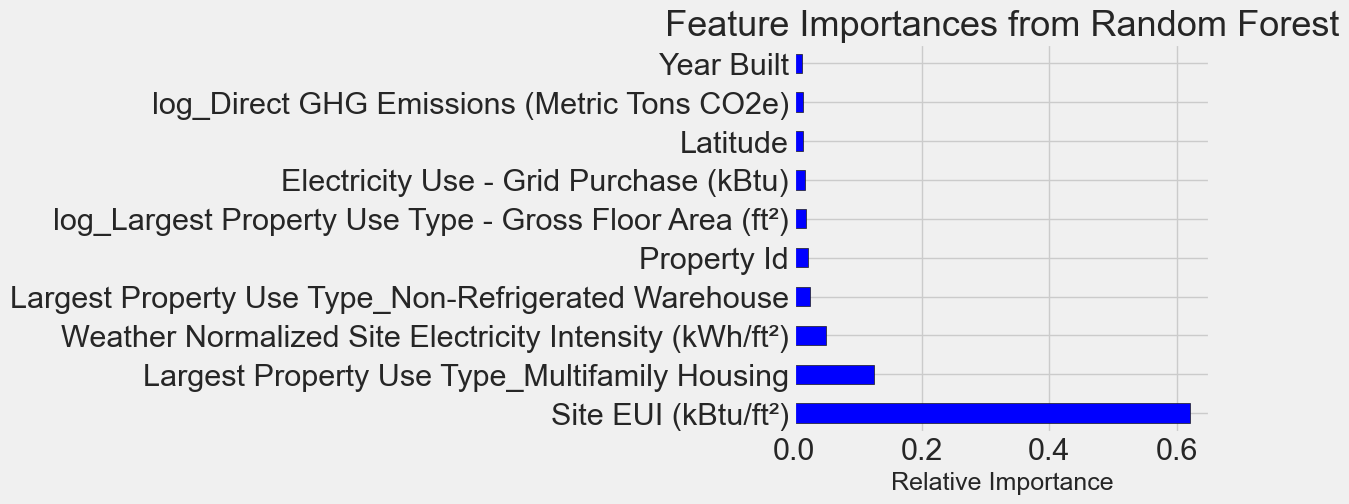

In [8]:
plt.figure(figsize=(14, 10))
plt.style.use('fivethirtyeight')

# Plot
feature_results.loc[:9, :].plot(
    x='feature', y='importance',
    kind='barh', color='blue', edgecolor='k', legend=False
)

# Labels and formatting
plt.xlabel('Relative Importance', size=18)
plt.ylabel('')
plt.title('Feature Importances from Random Forest', size=26)

# Adjust layout manually
plt.subplots_adjust(left=0.3, right=0.95)
plt.show()

## Use Feature Importances for Feature Selection

In [9]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (8802, 10)
Most important testing  features shape:  (3773, 10)


In [10]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4603.
Linear Regression Reduced Results: MAE = 14.5451.


Reducing the features did not improve the linear regression results. It turns out that the extra information in the features with low importance do actually improve performance. 

Let's look at using the reduced set of features in the gradient boosted regressor.

In [11]:
# Create the model with correct hyperparameters
model_reduced = GradientBoostingRegressor(
    loss='absolute_error',  # ✅ fixed
    max_depth=5,
    max_features=None,
    min_samples_leaf=6,
    min_samples_split=6,
    n_estimators=800,
    random_state=42
)

# Fit and predict on reduced features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

# Print MAE
print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.5628


The model results are slightly worse with the reduced set of features and we will keep all of the features for the final model.

## Locally Interpretable Model-agnostic Explanations

We will look at using LIME to explain individual predictions made the by the model. LIME is a relatively new effort aimed at showing how a machine learning model thinks by approximating the region around a prediction with a linear model.

In [12]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [13]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 5.9459
Actual Value: 92.0000


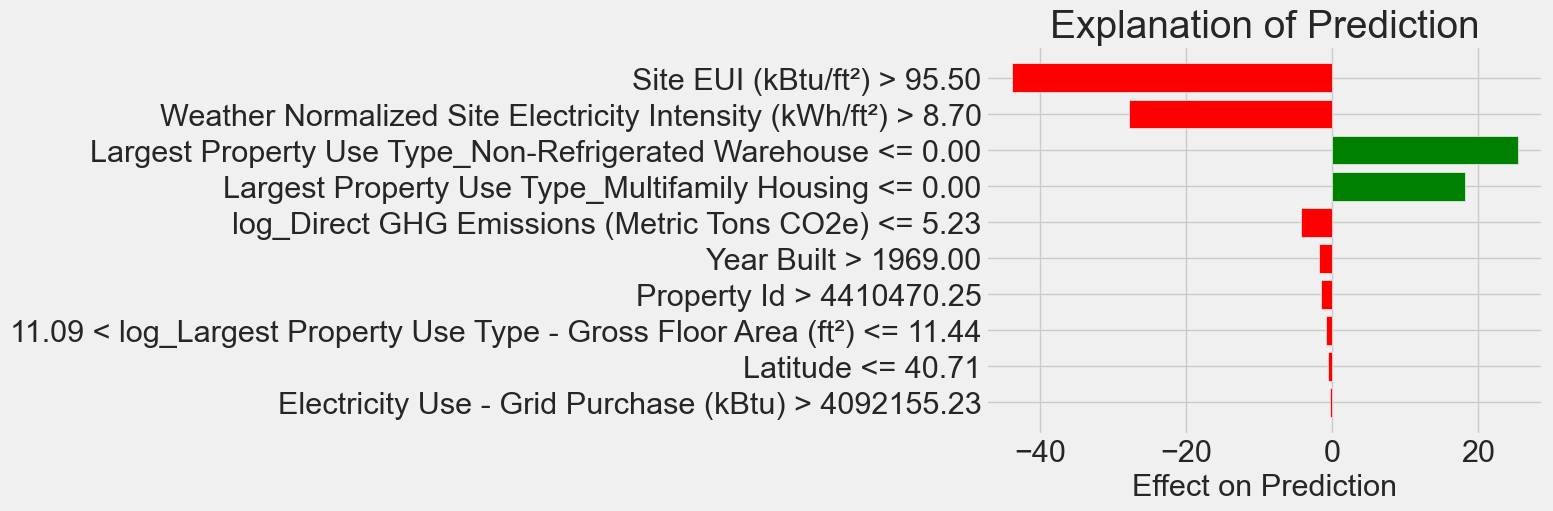

In [14]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1))[0])
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);
plt.show()

In [15]:
wrong_exp.show_in_notebook(show_predicted_value=False)

In this example, our gradient boosted model predicted a score of 5.9459 and the actual value was 100. 

The plot from LIME is showing us the contribution to the final prediction from each of the features for the example. We can see that the Site EUI singificantly decreased the prediction because it was above 95.50. TheLargest Property Use Type_Non-Refrigerated Warehouse on the other hand, increased the prediction because it was lower. 

We can interpret this as saying that our model thought the Energy Star Score would be much lower than it actually was because the Site EUI was high. However, in this case, the score was 100 despite the high value of the EUI. While this significant mistake might initially have been confusing, now we can see that in reality, the model was reasoning through the problem and just arrived at the incorrect value. 

Now we can go through the same process with a prediction the model got correct.

Prediction: 100.0000
Actual Value: 100.0000


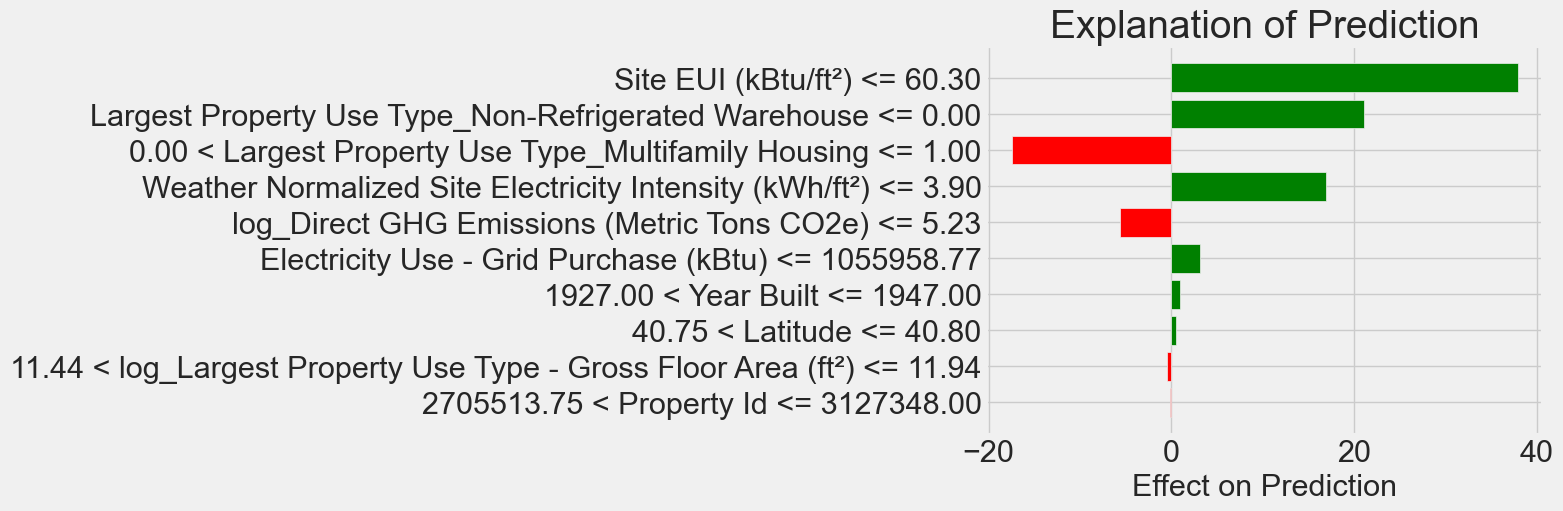

In [16]:
# Display the predicted and true value for the most accurate prediction
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1))[0])  # ← [0] added
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# LIME explanation for correct prediction
right_exp = explainer.explain_instance(
    data_row=right,
    predict_fn=model_reduced.predict,
    num_features=10
)

# Plot the explanation
right_exp.as_pyplot_figure()
plt.title('Explanation of Prediction', size=28)
plt.xlabel('Effect on Prediction', size=22)
plt.show()

In [17]:
right_exp.show_in_notebook(show_predicted_value=False)

The correct value for this case was 100 which our gradient boosted model got right on.

The plot from LIME again shows the contribution to the prediciton of each of feature variables for the example. For instance, because the Site EUI was less than 60.30, that contributed significantly to a higher estimate of the score. Likewise, the year built being less than 1947 also positively contributed to the final prediction. 

## Examining a Single Decision Tree

We will first extract a tree from the forest and then save it using `sklearn.tree.export_graphviz`.

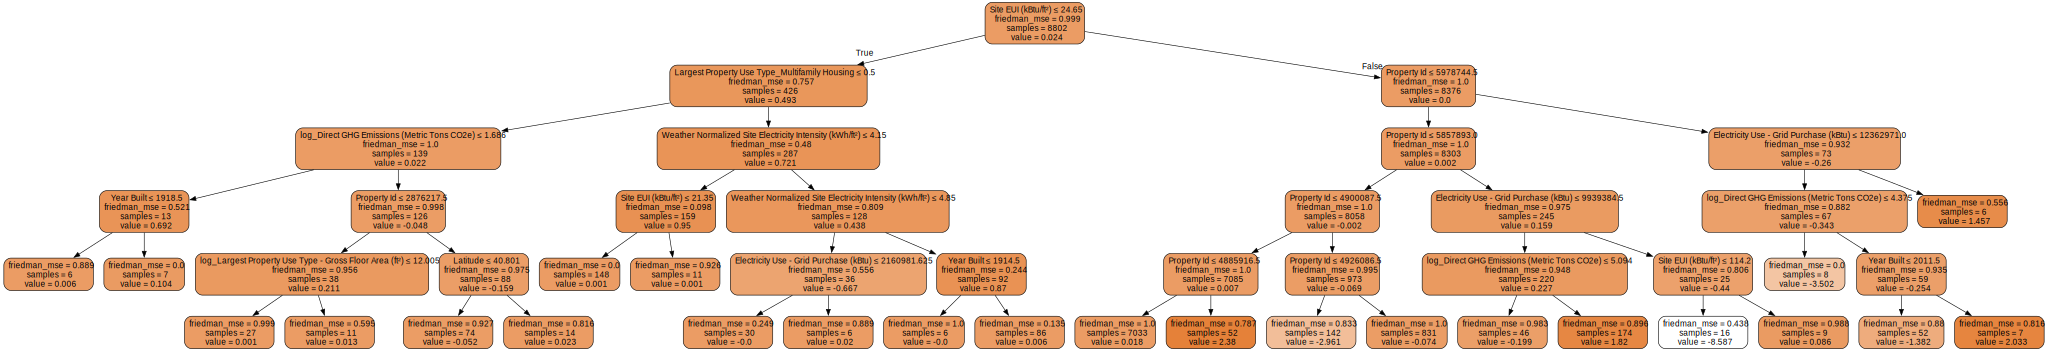

In [18]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import display

# Extract tree number 105 from the ensemble
single_tree = model_reduced.estimators_[105][0]

# Generate DOT format in memory
dot_data = export_graphviz(
    single_tree,
    out_file=None,
    feature_names=most_important_features,
    filled=True,
    rounded=True,
    special_characters=True
)

# Render and display inline in notebook
graph = Source(dot_data)
display(graph)

We can see that as we increase the depth of the tree, we will be better able to fit the data. With a small tree, there will be many examples in each leaf node, and because the model estimates the same value for each example in a node, there will probably be a larger error (unless all of the examples have the same target value). Constructing too large of a tree though can lead to overfitting. We can control a number of hyperparameters that determine the depth of the tree and the number of examples in each leaf.

## Conclusion: Key Determinants of Energy Star Score

The feature importance analysis from the model highlights that **energy-related metrics** are the most influential factors affecting a building's energy performance and efficiency. Specifically, the model identifies the following top predictors:

- **Site Energy Use Intensity (EUI)** is the most significant feature, accounting for the majority of the model’s decision-making weight. This indicates that buildings with lower energy use per square foot are strongly associated with better energy efficiency and higher Energy Star scores.

- **Largest Property Use Type_Multifamily Housing** also plays a prominent role, reflecting that residential buildings, particularly multifamily housing, have distinct energy profiles and energy efficiency benchmarks.

- Additional variables like **Weather Normalized Site Electricity Intensity** and **Electricity Use - Grid Purchase** contribute to the model, indicating that both actual energy consumption and external factors like weather conditions significantly affect energy performance.

- **Property Id** and **Year Built** also demonstrate some importance, suggesting that certain building characteristics, including age and specific identifiers, can influence energy efficiency ratings.

In conclusion, **energy consumption per square foot** is the dominant factor in determining a building's energy efficiency, while other features like **property type**, **electricity usage**, and **building age** also contribute to the overall energy performance as reflected in the Energy Star score.

### Final Insight

The findings from the model are consistent with the underlying principles of the Energy Star scoring system — promoting energy-efficient buildings that optimize their **energy consumption, emissions, and overall sustainability**. These insights can guide building owners, facility managers, and policymakers in identifying key operational factors to target for energy improvements, retrofits, and resource conservation efforts.
